In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import os
import sys
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
from dotmap import DotMap

In [7]:
PROJECT_PATH = '../'
DATA_DIR = "/home/swei20/AE/data/"
PCA_PATH = '/scratch/ceph/dobos/data/pfsspec/import/stellar/rbf/bosz_5000_full/pca/spectra.h5'
NORM_PATH = '/scratch/ceph/dobos/data/pfsspec/import/stellar/rbf/bosz_5000_full/norm/spectra.h5'

sys.path.insert(0, PROJECT_PATH)

In [8]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [9]:
import tensorflow as tf
# tf.enable_v2_behavior()
gpus = tf.config.list_physical_devices('GPU') 
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Load data

In [10]:
with h5py.File(NORM_PATH, 'r') as f:
    flux = f['flux'][()]
    mask = f['flux_idx'][()]

    wave = f['wave'][()]
#     eigv = f['flux_eigv'][()]

In [11]:
para = pd.DataFrame(data=np.transpose(np.where(mask)), columns=["F","T","L","C","O"])

In [55]:
idx0 = para[(para["O"] == 1)].index
idx00 = para[(para["O"] == 1)&(para["C"] == 1)].index

In [13]:
para.iloc[id_test]

,F,T,L,C,O
1,0,0,0,1,1
5,0,0,0,2,1
9,0,0,0,3,1
13,0,0,0,4,1
17,0,0,0,5,1
...,...,...,...,...,...
38413,13,12,10,1,1
38417,13,12,10,2,1
38421,13,12,10,3,1
38425,13,12,10,4,1


In [14]:
flux0 = flux[mask]

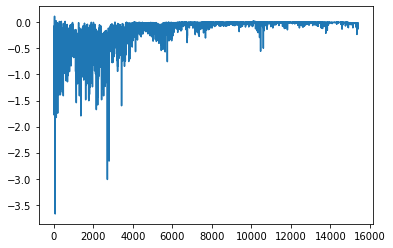

In [15]:
plt.plot(flux0[0])

## Robust PCA

In [16]:
def get_flux_in_Wrange(flux, wave, Ws):
    start = np.digitize(Ws[0], wave)
    end = np.digitize(Ws[1], wave)
    return flux[..., start:end], wave[start:end]

In [17]:
flux1, wave1 = get_flux_in_Wrange(flux0, wave, [3800, 13000])

In [18]:
flux2 = np.clip(-flux1, 0, None)

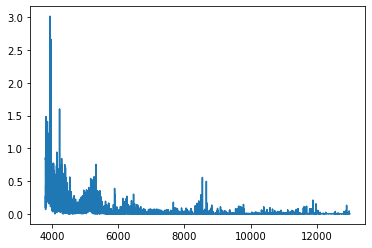

In [19]:
plt.plot(wave1, flux2[0])

In [20]:
from lv.rpca import RPCA
from lv.rpca_jkarnows import rpcaADMM

In [21]:
wave1

array([ 3800.3757,  3800.7556,  3801.1357, ..., 12996.7305, 12998.0312,
       12999.3311])

In [22]:
flux_test, wave_test = get_flux_in_Wrange(flux2, wave1, [4500, 9800])

In [64]:
flux3, wave3 = get_flux_in_Wrange(flux2, wave1, [8000, 9500])

In [65]:
flux3_00 = flux3[idx00]

In [66]:
flux3_00.shape

(1909, 1718)

In [67]:
SAVE_PATH = "/home/swei20/LV/data/w8_95.h5"

In [70]:
para.iloc[idx00].values

array([[ 0,  0,  0,  1,  1],
       [ 0,  0,  1,  1,  1],
       [ 0,  0,  2,  1,  1],
       ...,
       [13, 12,  8,  1,  1],
       [13, 12,  9,  1,  1],
       [13, 12, 10,  1,  1]])

In [83]:
flux4, wave4 = get_flux_in_Wrange(flux2, wave1, [4500, 9800])

In [84]:
flux4.shape

(38432, 7783)

In [85]:
SAVE_PATH = "/home/swei20/LV/data/w45_98.h5"
save(SAVE_PATH, flux4, wave4, para, para.index)

In [72]:
def save(SAVE_PATH, flux, wave, para, idx):
    with h5py.File(SAVE_PATH, 'w') as f:
        f.create_dataset('flux', data = flux, shape=flux.shape)
        f.create_dataset('wave', data = wave)
        f.create_dataset('para', data = para.iloc[idx].values)

In [71]:
with h5py.File(SAVE_PATH, 'w') as f:
    f.create_dataset('flux', data = flux3_00, shape=flux3_00.shape)
    f.create_dataset('wave', data = wave3)
    f.create_dataset('para', data = para.iloc[idx00].values)

In [25]:
flux_test.shape

(38432, 4105)

In [73]:
flux2.shape

(38432, 12299)

In [74]:
wave1.shape

(12299,)

In [79]:
para.iloc[para.index]

,F,T,L,C,O
0,0,0,0,1,0
1,0,0,0,1,1
2,0,0,0,1,2
3,0,0,0,1,3
4,0,0,0,2,0
...,...,...,...,...,...
38427,13,12,10,4,3
38428,13,12,10,5,0
38429,13,12,10,5,1
38430,13,12,10,5,2


In [80]:
SAVE_PATH = "/home/swei20/LV/data/full.h5"
save(SAVE_PATH, flux2, wave1, para, para.index)

In [ ]:
flux_test, wave_test = get_flux_in_Wrange(flux2, wave1, [6500, 9800])

# wave 6500 - 9800 #wave=4105

## #spectra 38432

In [49]:
X =flux_test

In [ ]:
h = rpcaADMM(X)


iter	    r norm	   eps pri	    s norm	  eps dual	 objective
   1	  726.6321	   13.1607	 1098.5192	   12.8851	 183509.39
  10	  198.4063	   16.4561	  125.0211	   13.8606	 800872.96
  20	   48.4254	   17.8286	   50.4195	   12.2674	 834245.03


In [86]:
h

{'objval': array([ 183509.38674833,  853074.85664224, 1495565.23915472,
        1540564.22012383, 1155994.81661257,  823194.53999945,
         646015.01276341,  586434.24578963,  649978.98892377,
         800872.95864985,  936711.15962573,  977068.18536391,
         925503.95848323,  836588.03439823,  763474.69260388,
         732336.19733719,  742637.69295379,  776733.78592139,
         812745.38169868,  834245.02744373,  835005.73500379,
         820204.70981263,  801995.8499028 ,  790625.44063843,
         788297.61998551,  791484.97716353,  796256.55894439,
         800526.95972562,  803610.50353804,  805301.79393142,
         805617.31862595,  804699.9305687 ,  802624.02847554,
              0.        ,       0.        ,       0.        ,
              0.        ,       0.        ,       0.        ,
              0.        ,       0.        ,       0.        ,
              0.        ,       0.        ,       0.        ,
              0.        ,       0.        ,       0.        

In [53]:
res = h["X1_admm"] + h["X2_admm"] + h["X3_admm"] - X

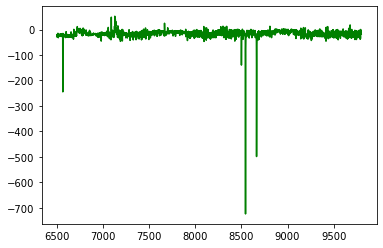

In [82]:
plt.plot(wave_test, -res.sum(0), label="Res - 3k", c='g')

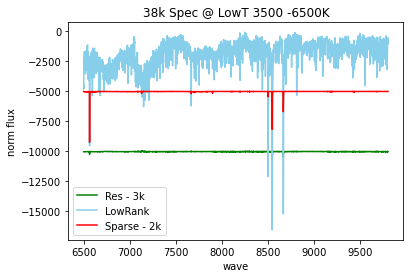

In [81]:
plt.plot(wave_test, -res.sum(0)-10000, label="Res - 3k", c='g')
plt.plot(wave_test, -h["X3_admm"].sum(0), label = "LowRank", c='skyblue')

plt.plot(wave_test, -h["X2_admm"].sum(0)-5000, label="Sparse - 2k", c='r')
plt.xlabel("wave")
plt.ylabel("norm flux")
plt.title("38k Spec @ LowT 3500 -6500K")
plt.legend()

## #spectra 9631 @ O/M = 0.0

In [26]:
X =flux_test00 #(9631, 4105)
h = rpcaADMM(X)


iter	    r norm	   eps pri	    s norm	  eps dual	 objective
   1	  325.0235	    5.9321	  484.3074	    5.8043	  34274.05
  10	   84.7642	    7.3108	   54.4751	    6.2301	 155560.08
  20	   20.5487	    7.9529	   23.2517	    5.4544	 161516.83
  30	   11.4010	    7.9452	    8.4634	    5.2613	 155281.83


In [33]:
h["X2_admm"].sum(0)

array([0.00460325, 2.09104942, 0.0300552 , ..., 0.        , 0.        ,
       0.        ])

In [40]:
Y = h["X1_admm"] + h["X2_admm"] + h["X3_admm"]

In [42]:
ress = Y - X

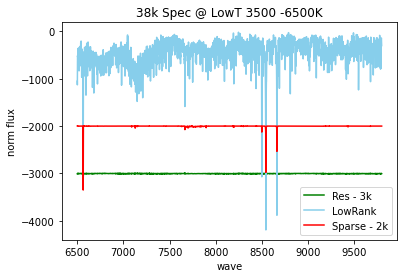

In [46]:
plt.plot(wave_test, -ress.sum(0)-3000, label="Res - 3k", c='g')
plt.plot(wave_test, -h["X3_admm"].sum(0), label = "LowRank", c='skyblue')

plt.plot(wave_test, -h["X2_admm"].sum(0)-2000, label="Sparse - 2k", c='r')
plt.xlabel("wave")
plt.ylabel("norm flux")
plt.title("38k Spec @ LowT 3500 -6500K")
plt.legend()

In [26]:
h = rpcaADMM(X)


iter	    r norm	   eps pri	    s norm	  eps dual	 objective
   1	  325.0235	    5.9321	  484.3074	    5.8043	  34274.05
  10	   84.7642	    7.3108	   54.4751	    6.2301	 155560.08
  20	   20.5487	    7.9529	   23.2517	    5.4544	 161516.83
  30	   11.4010	    7.9452	    8.4634	    5.2613	 155281.83


In [33]:
h["X2_admm"].sum(0)

array([0.00460325, 2.09104942, 0.0300552 , ..., 0.        , 0.        ,
       0.        ])

In [40]:
Y = h["X1_admm"] + h["X2_admm"] + h["X3_admm"]

In [42]:
ress = Y - X

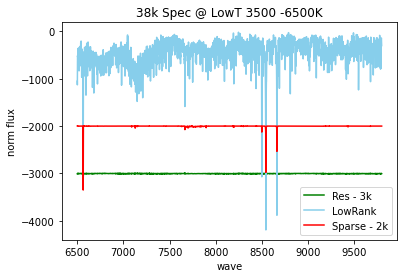

In [46]:
plt.plot(wave_test, -ress.sum(0)-3000, label="Res - 3k", c='g')
plt.plot(wave_test, -h["X3_admm"].sum(0), label = "LowRank", c='skyblue')

plt.plot(wave_test, -h["X2_admm"].sum(0)-2000, label="Sparse - 2k", c='r')
plt.xlabel("wave")
plt.ylabel("norm flux")
plt.title(f"Spec {X.shape} @ LowT 3500 -6500K")
plt.legend()

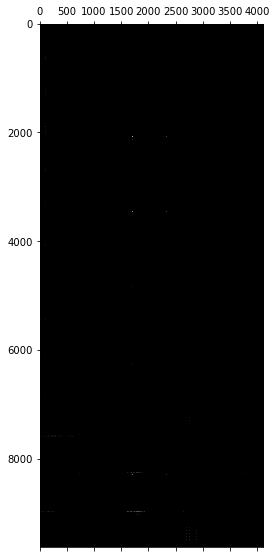

In [48]:
plt.matshow(h["X2_admm"], aspect="auto", cmap="gray", vmin=0)